In [60]:
#imports
fig_path = "/Users/conorosully/Google Drive/Trinity/Dissertation/Docs/Final/sections/figures/{}"

fontsize = 20

import numpy as np
import pandas as pd
import json

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_palette("Set2")
%matplotlib inline
from pandas.plotting import table

In [4]:
path = "/Users/conorosully/Documents/Legal-Case-Prediction/data/results/{}.csv"
autoML1 = pd.read_csv(path.format("results_autoML_final"))
autoML2 = pd.read_csv(path.format("results_autoML_final2"))
autoML = autoML1.append(autoML2)
print(len(autoML))
autoML.head(1)

path = "/Users/conorosully/Documents/Legal-Case-Prediction/data/results/{}.csv"
results_test = pd.read_csv(path.format("results_test"))

print(len(results_test))
results_test.head(1)

path = "/Users/conorosully/Documents/Legal-Case-Prediction/data/clean/{}.json"

with open(path.format('train_test_split_update'), 'r') as readfile:
    train_test_split = json.load(readfile)
    readfile.close()

1080
12


In [111]:
1080/12

90.0

### Commonly used

In [5]:
article_labels = ['Article 2', 'Article 3', 'Article 5', 'Article 6', 'Article 7', 'Article 8', 'Article 9', 'Article 10', 'Article 11', 'Article 13', 'Article 14', 'Article 18']
articles_all = [ 2,  3,  5,  6,  7,  8,  9, 10, 11, 13, 14, 18]
articles_1 = [ 3,  6, 8]
articles_2 = [ 2,  3,  5,  6,  8,  10, 11, 13, 14]

weights_all = []
weights_1 = []
weights_2 = []
for a in articles_all:
    article = str(a)
    weight = len(train_test_split[article]['v_train']) + len(train_test_split[article]['nv_train'])
    weights_all.append(weight)
    if a in articles_1:
        weights_1.append(weight)
    if a in articles_2:
        weights_2.append(weight)
        
print(len(weights_all),len(weights_1),len(weights_2))


12 3 9


# Best Training Accuracy

In [6]:
best = autoML.sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')
train_accuracy = best['train']

In [50]:
def autolabel(rects,x):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(x, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha='center', va='bottom',
                   fontsize = 12)

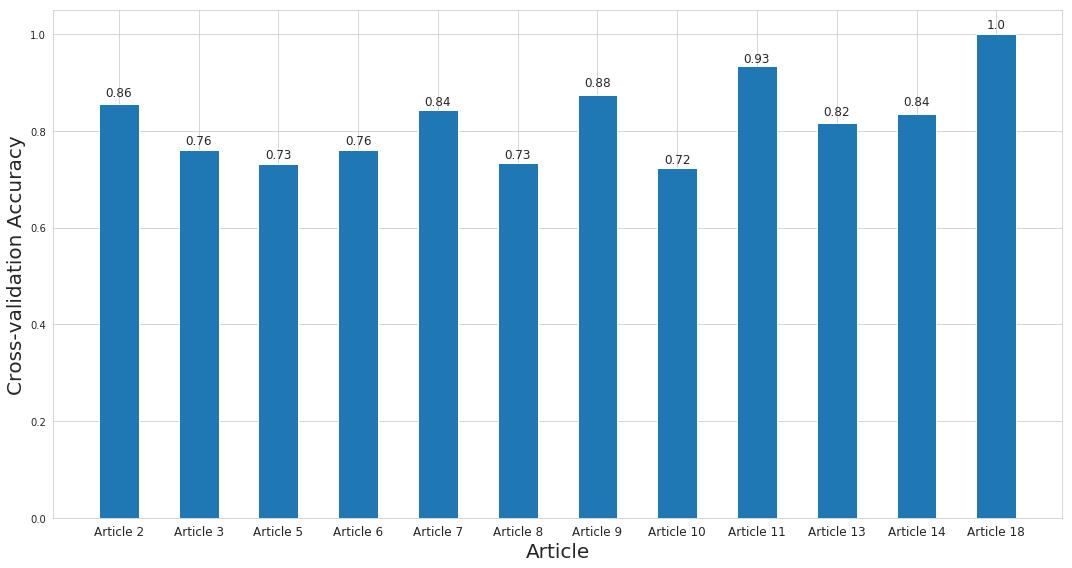

In [29]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

labels = article_labels
x = np.arange(len(labels)) 

width = 0.5
rec = plt.bar(x = x,height = train_accuracy,width=width)
autolabel(rec)
"""for scores, part in zip(train_scores,parts):
    plt.stem(x, scores,label=part)
    
    #sns.lineplot(x=x,y=scores,label=part)"""
    
ax.set_xlabel('Article', fontsize = fontsize)
ax.set_ylabel('Cross-validation Accuracy', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
#plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig(fig_path.format("best_training_accuracy.eps"),format='eps',dpi=1000)

In [33]:
#Calculations
mean_all = np.mean(best['train'])
weighted_all = sum(np.array(best['train'])*weights_all)/sum(weights_all)
print(mean_all,weighted_all)

best_1 = best[best['article'].isin(articles_1)]
mean_1 = np.mean(best_1['train'])
weighted_1 = sum(np.array(best_1['train'])*weights_1)/sum(weights_1)
print(mean_1,weighted_1)

best_2 = best[best['article'].isin(articles_2)]
mean_2 = np.mean(best_2['train'])
weighted_2 = sum(np.array(best_2['train'])*weights_2)/sum(weights_2)
print(mean_2,weighted_2)

0.8225185 0.7728734963089153
0.7515363333333335 0.7534313176470588
0.794608 0.768590935731132


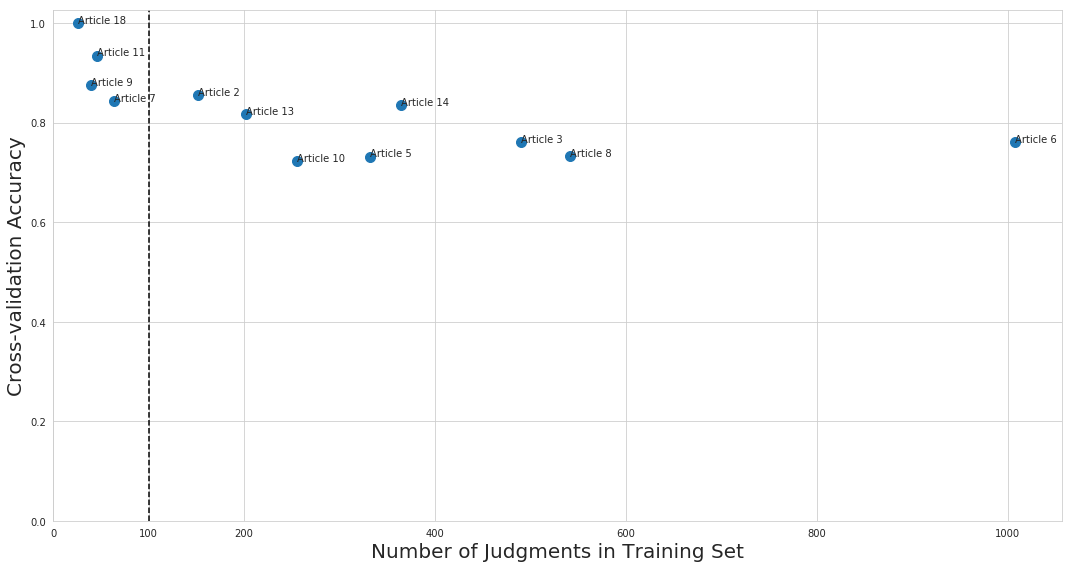

In [82]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

plt.scatter(x=weights_all,y=best['train'],s=100)

ax.set_xlabel('Number of Judgments in Training Set', fontsize = fontsize)
ax.set_ylabel('Cross-validation Accuracy', fontsize = fontsize)
plt.xticks([0,100,200,400,600,800,1000])
#ax.set_xticklabels(labels,fontsize=12)
#plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
for i, txt in enumerate(article_labels):
    ax.annotate(txt, (weights_all[i], list(best['train'])[i]))
    
plt.axvline(x=100, color='black', linestyle='--')
#ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

plt.tight_layout()

plt.savefig(fig_path.format("accuracyVdata.eps"),format='eps',dpi=1000)


In [23]:
#Training Models
hyper_params = results_test[['article','type','dimension','part','stopwords','model']]
hyper_params['article'] = article_labels

def getClassifier(model):
    classifier = model.split("'classifier:__choice__':")[1].split(",")[0].split("'")[1]
    return classifier
hyper_params['model'] = [getClassifier(m) for m in hyper_params['model']]


hyper_params.replace(['law','echr','glove'],['law2vec','echr2vec','GloVe'],inplace = True)
hyper_params.replace(['english','none'],['Yes','No'],inplace = True)
hyper_params.replace('both','procedure+facts',inplace = True)

hyper_params.replace(['gradient_boosting','random_forest',"sgd","decision_tree","adaboost","qda"],
                     ['Gradient Boosting','Random Forest'," SGD","Decision Tree","AdaBoost","Quadratic Classifier"],inplace = True)

hyper_params.columns =  ["Article","Feature Type","Dimension","Part","Stopwords","Classifier"]
hyper_params.to_csv(fig_path.format("model_params.csv"))

hyper_params

/Users/conorosully/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/conorosully/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Article,Feature Type,Dimension,Part,Stopwords,Classifier
0,Article 2,law2vec,100,circumstances,Yes,Gradient Boosting
1,Article 3,GloVe,200,procedure+facts,No,Random Forest
2,Article 5,GloVe,200,relevant,Yes,Gradient Boosting
3,Article 6,echr2vec,100,procedure+facts,Yes,SGD
4,Article 7,GloVe,200,circumstances,No,Decision Tree
5,Article 8,echr2vec,100,procedure+facts,Yes,Random Forest
6,Article 9,ngram,2000,circumstances,Yes,AdaBoost
7,Article 10,echr2vec,200,procedure+facts,No,Quadratic Classifier
8,Article 11,GloVe,200,procedure+facts,Yes,SGD
9,Article 13,GloVe,100,procedure+facts,Yes,Quadratic Classifier


In [93]:
# Pipelines
for a,m in zip(article_labels,results_test['model']):
    print("\textbf{"+ a + "}: ")
    print()
    for s in m.split(","):
        print(s)



	extbf{Article 2}: 

[(1.000000
 SimpleClassificationPipeline({'preprocessor:__choice__': 'no_preprocessing'
 'rescaling:__choice__': 'standardize'
 'balancing:strategy': 'none'
 'classifier:gradient_boosting:min_impurity_decrease': 0.0
 'classifier:gradient_boosting:min_samples_leaf': 13
 'classifier:gradient_boosting:max_features': 0.609076475500038
 'imputation:strategy': 'most_frequent'
 'classifier:gradient_boosting:min_weight_fraction_leaf': 0.0
 'categorical_encoding:__choice__': 'one_hot_encoding'
 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True'
 'classifier:gradient_boosting:max_depth': 2
 'classifier:gradient_boosting:criterion': 'mse'
 'classifier:gradient_boosting:max_leaf_nodes': 'None'
 'classifier:gradient_boosting:min_samples_split': 9
 'classifier:gradient_boosting:loss': 'deviance'
 'classifier:gradient_boosting:subsample': 0.6024121853927239
 'classifier:gradient_boosting:learning_rate': 0.04672091880080751
 'classifier:gradient_boosting:n_estima

# Test Accuracy

In [52]:
best.head()

,type,dimension,article,part,stopwords,train,test,model,stats,predictions
66,law,100,2,circumstances,english,0.855263,0.854839,"[(1.000000, SimpleClassificationPipeline({'cla...",auto-sklearn results:\n Dataset name: legal_j...,[1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1...
92,glove,200,3,both,none,0.761224,0.786885,"[(1.000000, SimpleClassificationPipeline({'bal...",auto-sklearn results:\n Dataset name: legal_j...,[0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1...
263,glove,200,5,relevant,english,0.731928,0.636872,"[(1.000000, SimpleClassificationPipeline({'cla...",auto-sklearn results:\n Dataset name: legal_j...,[1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1...
284,echr,100,6,both,english,0.760913,0.727069,"[(1.000000, SimpleClassificationPipeline({'imp...",auto-sklearn results:\n Dataset name: legal_j...,[1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1...
55,glove,200,7,circumstances,none,0.843750,0.666667,"[(1.000000, SimpleClassificationPipeline({'pre...",auto-sklearn results:\n Dataset name: legal_j...,[1 0 1 1 0 1 0 1 0]


In [6]:
results_test['train'] = list(best['train'])
results_test.head(1)

,type,dimension,article,part,stopwords,train,test,model,stats,predictions,actual
0,law,100,2,circumstances,english,0.855263,0.80303,"[(1.000000, SimpleClassificationPipeline({'pre...",auto-sklearn results:\n Dataset name: legal_j...,[1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1...,0 1\n1 1\n2 1\n3 1\n4 1\n ...


In [12]:
def getPreds(predictions):
    pred = []
    for p in predictions:
        if (p == '1') | (p == '0'):
            pred.append(int(p))
    return pred

preds = [getPreds(row) for row in results_test["predictions"]]
len(preds)

path = "/Users/conorosully/Documents/Legal-Case-Prediction/data/test_features/{}.csv"

actual = []
for row in results_test.values:
    filename = "test_{}_{}_{}_{}_{}".format(row[0],row[1],row[2],row[3],row[4])
    df_test = pd.read_csv(path.format(filename))
    actual.append(list(df_test["target"]))
len(actual)

accuracy = []
precison = []
recall = []
for a,p,x in zip(actual,preds,results_test['test']):
    accuracy.append(accuracy_score(a,p))
    precison.append(precision_score(a,p))
    recall.append(recall_score(a,p))

heuristic = []
for a in actual:
    v = sum(a)
    nv = len(a) - sum(a)
    if v > nv:
        h = v/len(a)
    else:
        h = nv/len(a)        
    heuristic.append(h) 

In [43]:
y1 = list(results_test['test']) +[0.6882]
y2 = heuristic + [0.8668]
y1

[0.803030303030303,
 0.7376237623762376,
 0.6774193548387096,
 0.6773109243697479,
 0.6666666666666666,
 0.7073170731707317,
 0.5714285714285714,
 0.4576271186440678,
 0.7058823529411765,
 0.7114093959731543,
 0.675,
 0.6666666666666666,
 0.6882]

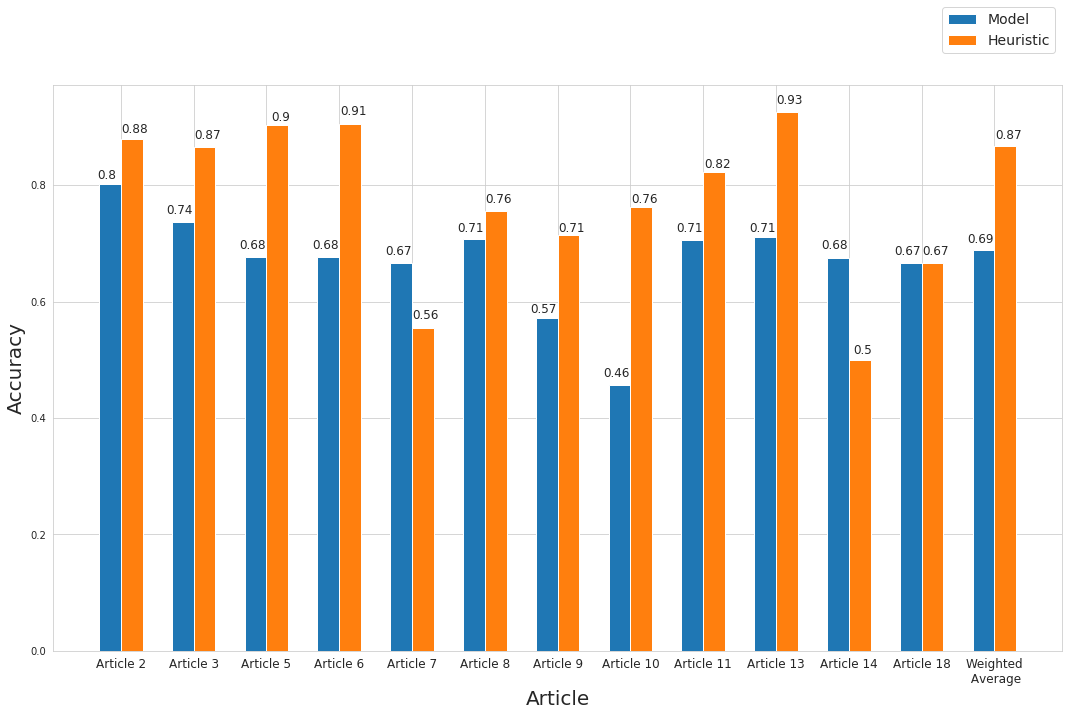

In [55]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,10))

labels = ["Article {}".format(z) for z in results_test['article']] +["Weighted\n Average"]
x = np.arange(len(labels))

width = 0.3


#plt.bar(x = x-width,height = results_test['train'],width=width,label='Train Accuracy')
rec1 = plt.bar(x = x-width/2,height = y1,width=width,label='Model')
rec2 = plt.bar(x = x+width/2,height = y2,width=width,label='Heuristic')
#plt.bar(x = x+width*1.5,height = recall,width=width,label='Test Recall')
autolabel(rec1,-3)
autolabel(rec2,3)

ax.set_xlabel('Article', fontsize = fontsize)
ax.set_ylabel('Accuracy', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
plt.legend(fontsize=14,bbox_to_anchor=(1, 1.15))
plt.tight_layout()

plt.savefig(fig_path.format("test_results_accuracy.eps"),format='eps',dpi=1000)

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

plt.scatter(x=weights_all,y=best['train'],s=100)

ax.set_xlabel('Number of Judgments in Training Set', fontsize = fontsize)
ax.set_ylabel('Cross-validation Accuracy', fontsize = fontsize)
plt.xticks([0,100,200,400,600,800,1000])
#ax.set_xticklabels(labels,fontsize=12)
#plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
for i, txt in enumerate(article_labels):
    ax.annotate(txt, (weights_all[i], list(best['train'])[i]))
    
plt.axvline(x=100, color='black', linestyle='--')

plt.tight_layout()

plt.savefig(fig_path.format("accuracyVdata.eps"),format='eps',dpi=1000)

In [34]:
diff = results_test['train'] - results_test['test'] 
su = 0
for d,a in zip(diff, article_labels):
    if a not in ['Article 7','Article 9','Article 11','Article 18']:
        print(a)
        su += d
su/8

Article 2
Article 3
Article 5
Article 6
Article 8
Article 10
Article 13
Article 14


0.07867950844963101

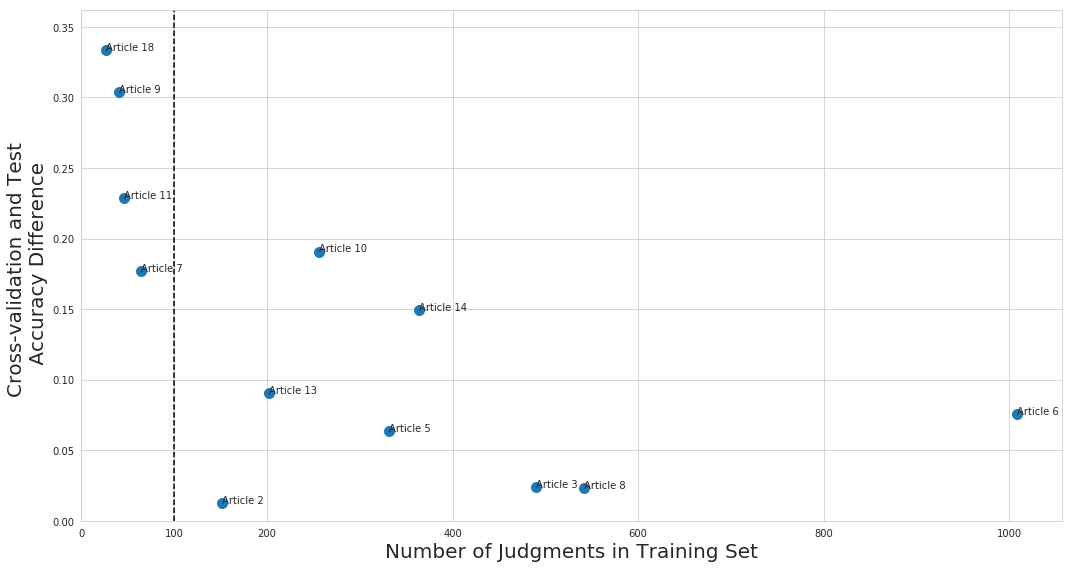

In [81]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))


plt.scatter(x=weights_all,y=diff,s=100)

ax.set_xlabel('Number of Judgments in Training Set', fontsize = fontsize)
ax.set_ylabel('Cross-validation and Test \n Accuracy Difference', fontsize = fontsize)
plt.xticks([0,100,200,400,600,800,1000])
#ax.set_xticklabels(labels,fontsize=12)
#plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
for i, txt in enumerate(article_labels):
    ax.annotate(txt, (weights_all[i], diff[i]))
    
plt.axvline(x=100, color='black', linestyle='--')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
plt.tight_layout()

plt.savefig(fig_path.format("differenceVdata.eps"),format='eps',dpi=1000)

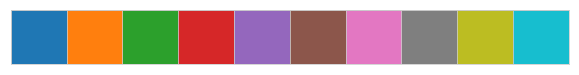

In [17]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [18]:
np.mean(recall)

0.690557705824341

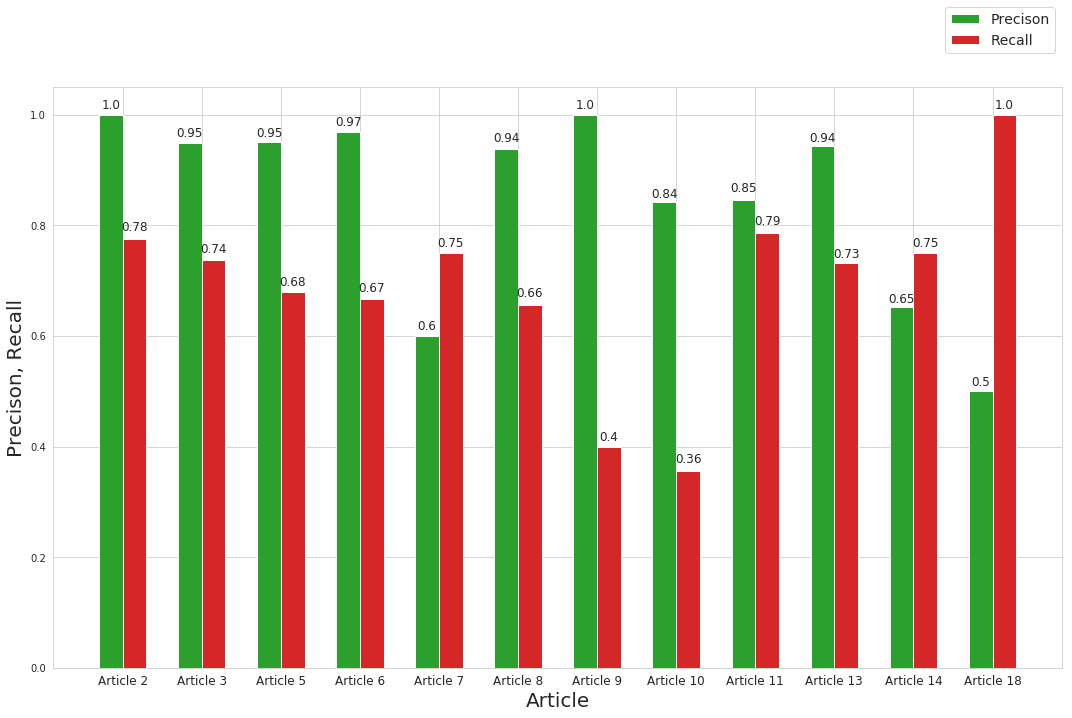

In [75]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,10))

labels = ["Article {}".format(x) for x in results_test['article']] 
x = np.arange(len(labels))

width = 0.3
#plt.bar(x = x-width,height = results_test['test'],width=width,label='Test Accuracy',color=current_palette[1])
rec1 = plt.bar(x = x-width/2,height = precison,width=width,label='Precison',color=current_palette[2])
rec2 = plt.bar(x = x+width/2,height = recall,width=width,label='Recall',color=current_palette[3])
autolabel(rec1,0)
autolabel(rec2,0)


ax.set_xlabel('Article', fontsize = fontsize)
ax.set_ylabel('Precison, Recall', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
plt.legend(fontsize=14,bbox_to_anchor=(1, 1.15))
plt.tight_layout()

plt.savefig(fig_path.format("test_precision_recall.eps"),format='eps',dpi=1000)

In [8]:
# Confusion matrices
confusion_matrix(actual[10],preds[10])

array([[12,  8],
       [ 5, 15]])

In [44]:
weights = []
for a in actual:
    weights.append(len(a))
weights    

mean = np.mean(accuracy)
weighted = sum(np.array(accuracy)*np.array(weights))/sum(weights)
print(mean,weighted)

mean = np.mean(heuristic)
weighted = sum(np.array(heuristic)*np.array(weights))/sum(weights)
print(mean,weighted)

0.6714485158421694 0.6881868131868132
0.7716044951786135 0.8667582417582418


In [63]:
round(precison[0],4)

1.0

In [70]:
results_values = results_test[['article','train','test']]
results_values['article'] = article_labels

results_values['train'] = [round(x,4) for x in results_values['train']]
results_values['test'] = [round(x,4) for x in results_values['test']]
results_values['precison'] = [round(x,4) for x in precison]
results_values['recall'] = [round(x,4) for x in recall]
results_values['heuristic'] = [round(x,4) for x in heuristic]

results_values.columns = ['Article', 'Training Accuracy', 'Test Accuracy', 'Test Precison', 'Test Recall', 'Heuristic Accuracy']
results_values.to_csv(fig_path.format("results.csv"))
results_values.head()

/Users/conorosully/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/conorosully/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/conorosully/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,Article,Training Accuracy,Test Accuracy,Test Precison,Test Recall,Heuristic Accuracy
0,Article 2,0.8553,0.8030,1.0000,0.7759,0.8788
1,Article 3,0.7612,0.7376,0.9485,0.7371,0.8663
2,Article 5,0.7319,0.6774,0.9500,0.6786,0.9032
3,Article 6,0.7609,0.6773,0.9677,0.6660,0.9059
4,Article 7,0.8438,0.6667,0.6000,0.7500,0.5556


# Accuracy by Parts

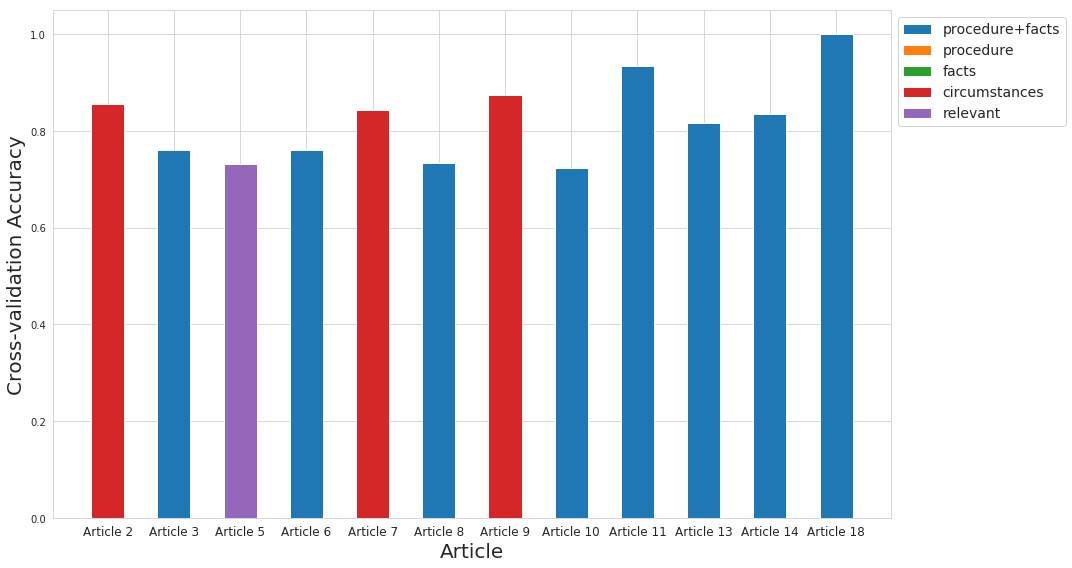

In [46]:
best_parts = autoML.sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')

labels = ["Article {}".format(x) for x in best_parts['article']] 
x = np.arange(len(labels)) 
x_parts = {'both':[0], 'procedure':[0], 'facts':[0], 'circumstances':[0], 'relevant':[0]}
height_parts = {'both':[0], 'procedure':[0], 'facts':[0], 'circumstances':[0], 'relevant':[0]}

for i,row in enumerate(best_parts.values):
    part = row[3]
    train = row[5]
    x_parts[part] = x_parts[part] + [x[i]]
    height_parts[part] = height_parts[part] + [train]
    
width = 0.5

fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

plt.bar(x_parts['both'],height = height_parts['both'] ,width=width,label='procedure+facts')
plt.bar(x_parts['procedure'],height = height_parts['procedure'] ,width=width,label='procedure')
plt.bar(x_parts['facts'],height = height_parts['facts'] ,width=width,label='facts')
plt.bar(x_parts['circumstances'],height = height_parts['circumstances'] ,width=width,label='circumstances')
plt.bar(x_parts['relevant'],height = height_parts['relevant'] ,width=width,label='relevant')


ax.set_xlabel('Article', fontsize = fontsize)
ax.set_ylabel('Cross-validation Accuracy', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig(fig_path.format("best_parts_single.eps"),format='eps',dpi=1000)

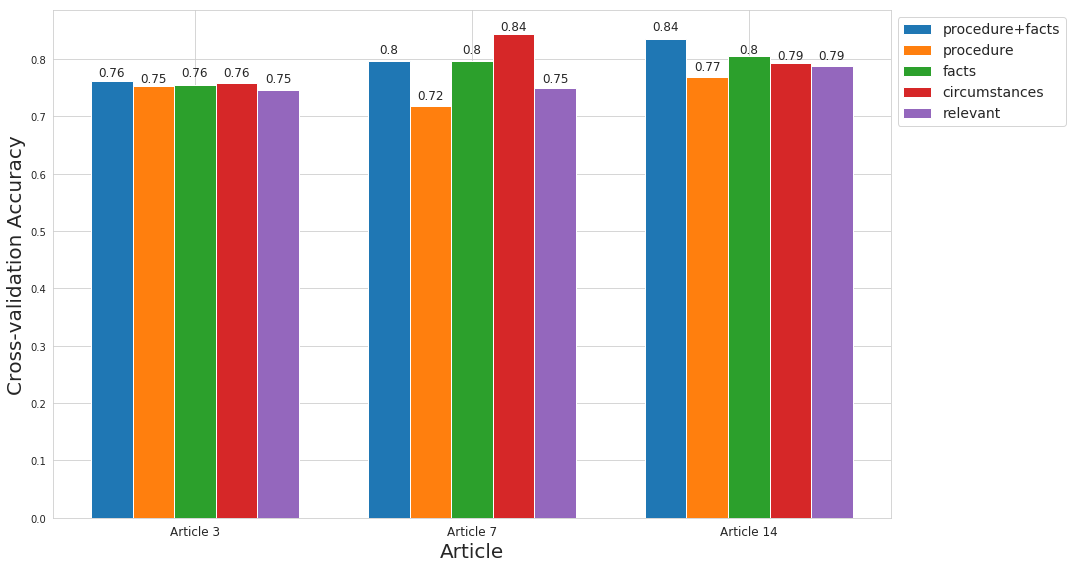

In [31]:
parts = ['both', 'procedure', 'facts', 'circumstances', 'relevant']
df_parts = []
train_scores = []
for part in parts:
    temp = autoML[autoML['article'].isin([3,7,14])]
    temp = temp[temp['part']==part].sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')
    df_parts.append(temp.copy())
    train_score = list(temp['train'])
    train_scores.append(train_score)

fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

labels = ["Article {}".format(x) for x in df_parts[0]['article']] 
x = np.arange(len(labels)) 

width = 0.15
rec1 = plt.bar(x = x-width*2,height = df_parts[0]['train'],width=width,label='procedure+facts')
rec2 = plt.bar(x = x-width*1,height = df_parts[1]['train'],width=width,label='procedure')
rec3 = plt.bar(x = x,height = df_parts[2]['train'],width=width,label='facts')
rec4 = plt.bar(x = x+width*1,height = df_parts[3]['train'],width=width,label='circumstances')
rec5 = plt.bar(x = x+width*2,height = df_parts[4]['train'],width=width,label='relevant')
#plt.bar(x = x + width/2,height = 'nv_used',width=width,data = data,label='nonviolation')
autolabel(rec1)
autolabel(rec2)
autolabel(rec3)
autolabel(rec4)
autolabel(rec5)
"""for scores, part in zip(train_scores,parts):
    plt.stem(x, scores,label=part)
    
    #sns.lineplot(x=x,y=scores,label=part)"""
    
ax.set_xlabel('Article', fontsize = fontsize)
ax.set_ylabel('Cross-validation Accuracy', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig(fig_path.format("part_variation.eps"),format='eps',dpi=1000)

both 0.8128933333333332 0.7700342163543441
procedure 0.7764599999999998 0.7356616768881318
facts 0.8023262500000001 0.7612151022146508
circumstances 0.8026726666666667 0.7563882549687677
relevant 0.7832880833333334 0.7424759085746735


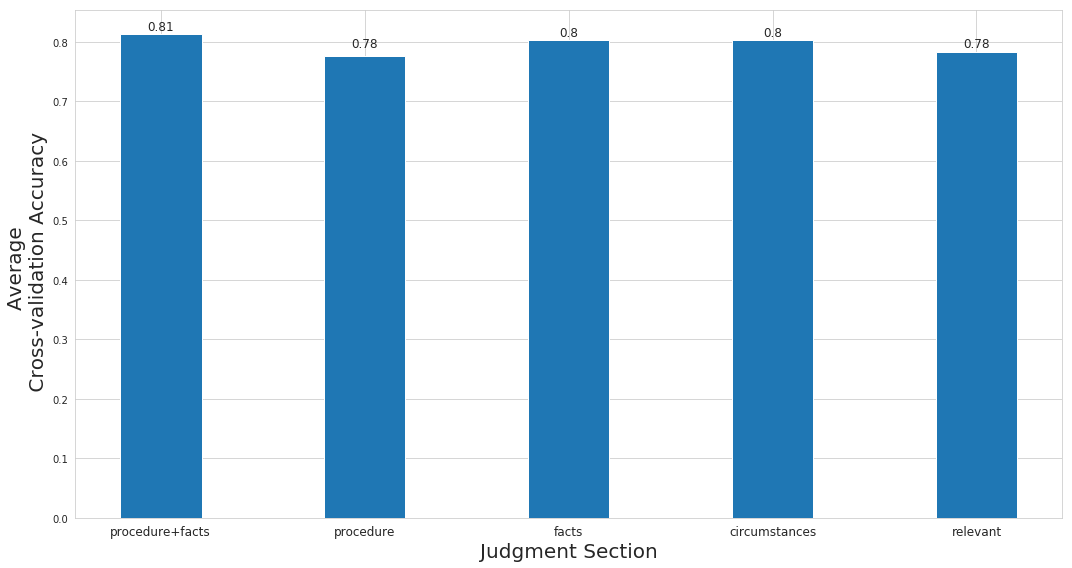

In [73]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

labels = ['procedure+facts', 'procedure', 'facts', 'circumstances', 'relevant']
x = np.arange(len(labels)) 
width =  0.4

parts = ['both', 'procedure', 'facts', 'circumstances', 'relevant']
means = []
weighteds = []
for part in parts:
    temp = autoML[autoML['part']==part].sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')
    train_score = list(temp['train'])
    mean = np.mean(train_score)
    weighted = sum(np.array(train_score)*np.array(weights_all))/sum(weights_all)
    means.append(mean)
    weighteds.append(weighted)
    print(part,mean,weighted)
    
rec1 = plt.bar(x = x,height = means,width=width,label='Average')
#rec2 = plt.bar(x = x+width/2,height = weighteds,width=width,label='Weighted Average')

autolabel(rec1,0)
#autolabel(rec2,0)

#plt.axhline(y=0.7700342163543441, color='black', linestyle='--')
    
ax.set_xlabel('Judgment Section', fontsize = fontsize)
ax.set_ylabel('Average \n Cross-validation Accuracy', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
#plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig(fig_path.format("average_part_all.eps"),format='eps',dpi=1000)

# Accuracy by Feature Type

2 law 0.8552629999999999
3 glove 0.761224
5 glove 0.731928
6 echr 0.7609130000000001
7 glove 0.84375
8 echr 0.732472
9 ngram 0.875
10 echr 0.722892
11 glove 0.934783
13 glove 0.816832
14 echr 0.8351649999999999
18 echr 1.0


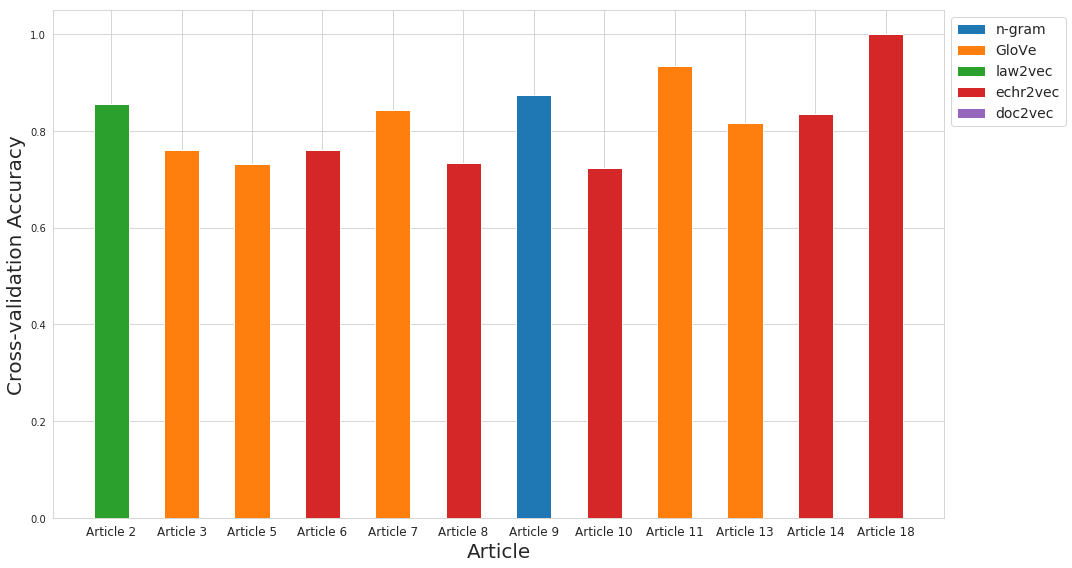

In [43]:
best_types = autoML.sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')

labels = ["Article {}".format(x) for x in best_types['article']] 
x = np.arange(len(labels)) 
x_type = {'ngram':[0], 'glove':[0], 'law':[0], 'echr':[0], 'doc':[0]}
height_type = {'ngram':[0], 'glove':[0], 'law':[0], 'echr':[0], 'doc':[0]}

for i,row in enumerate(best_types.values):
    part = row[0]
    train = row[5]
    x_type[part] = x_type[part] + [x[i]]
    height_type[part] = height_type[part] + [train]
width = 0.5

fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

plt.bar(x = x_type['ngram'],height = height_type['ngram'],width=width,label='n-gram')
plt.bar(x = x_type['glove'],height = height_type['glove'],width=width,label='GloVe')
plt.bar(x = x_type['law'],height = height_type['law'],width=width,label='law2vec')
plt.bar(x = x_type['echr'],height = height_type['echr'],width=width,label='echr2vec')
plt.bar(x = x_type['doc'],height = height_type['doc'],width=width,label='doc2vec')

ax.set_xlabel('Article', fontsize = fontsize)
ax.set_ylabel('Cross-validation Accuracy', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig(fig_path.format("best_feature_single.eps"),format='eps',dpi=1000)

ngram 0.7838410833333332
glove -0.010299083333333292
law -0.007750083333333491
echr -0.009619666666666582
doc -0.0009689166666665416


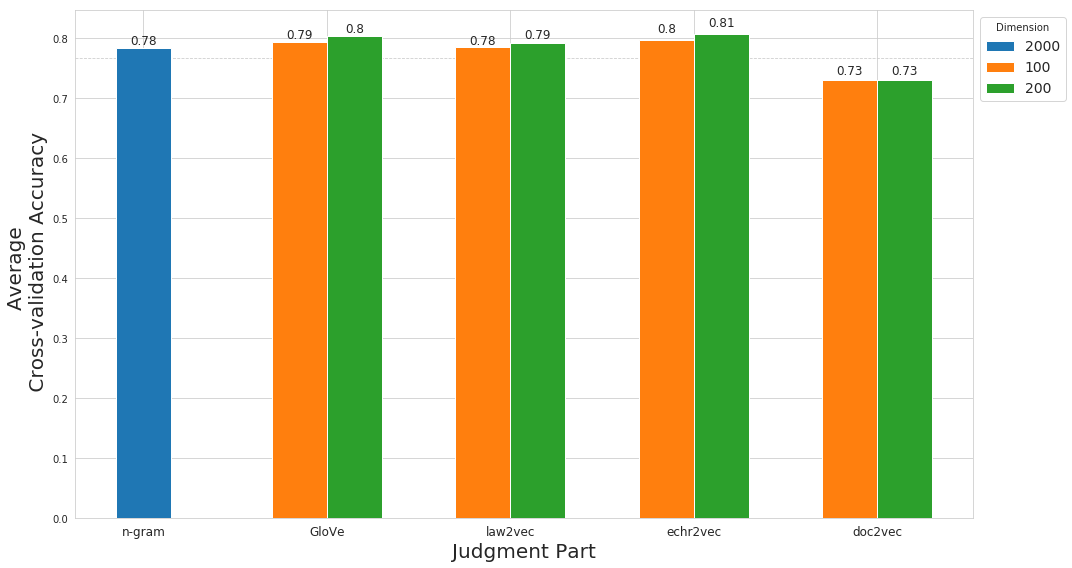

In [78]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))

labels = ['n-gram', 'GloVe', 'law2vec', 'echr2vec', 'doc2vec']
x = np.arange(len(labels)) 
x_2 = np.array([1,2,3,4])
width =  0.3

#ngram
temp = autoML[autoML['type']=='ngram'].sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')
train_score = list(temp['train'])
#ngram_weight = sum(np.array(train_score)*np.array(weights_all))/sum(weights_all)
ngram_weight = np.mean(train_score)
print("ngram",ngram_weight)

types = ['glove', 'law', 'echr', 'doc']

height_100 = []
height_200 = []
for t in types:
    temp = autoML[autoML['type']==t]
    temp_100 = temp[temp['dimension']==100].sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')
    temp_200 = temp[temp['dimension']==200].sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')
   
    #mean_100 = sum(np.array(temp_100['train'])*np.array(weights_all))/sum(weights_all)
    #mean_200  = sum(np.array(temp_200['train'])*np.array(weights_all))/sum(weights_all)
    
    mean_100 = np.mean(temp_100['train'])
    mean_200  = np.mean(temp_200['train'])
    
    
    height_100.append(mean_100)
    height_200.append(mean_200)
    print(t,mean_100 - mean_200)
    
rec1 = plt.bar(x = [0],height = ngram_weight,width=width,label='2000')
rec2 = plt.bar(x = x_2 - width/2,height = height_100,width=width,label='100')
rec3 = plt.bar(x = x_2 + width/2,height = height_200,width=width,label='200')

autolabel(rec1,0)
autolabel(rec2,0)
autolabel(rec3,0)

#plt.axhline(y=0.7700342163543441, color='black', linestyle='--')

ax.set_yticks([0.766], minor=True)
ax.yaxis.grid(True, which='minor', linestyle='--',)

    
ax.set_xlabel('Judgment Part', fontsize = fontsize)
ax.set_ylabel('Average \n Cross-validation Accuracy', fontsize = fontsize)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
plt.legend(fontsize=14,bbox_to_anchor=(1, 1),title = "Dimension")
plt.tight_layout()

plt.savefig(fig_path.format("average_type_dimesnion.eps"),format='eps',dpi=1000)

### Previous studies

In [27]:
data_1 = data_2 = np.array([250,80,254])
data_3 = np.array([568,916,458])


acc_1 = np.array([78.09,84.11,78.06])
acc_2 = np.array([73.4,87.5,77.7])
acc_3 = np.array([71,80,72])


print(np.mean(acc_1))
print(np.mean(acc_2))
print(np.mean(acc_3))

#print(sum(data_1*acc_1)/sum(data_1))
#print(sum(data_2*acc_2)/sum(data_2))
#print(sum(data_3*acc_3)/sum(data_3))

80.08666666666666
79.53333333333335
74.33333333333333


In [28]:
data_1 = np.array([114,568,300,916,458,212,64,212,288])
acc_1 = np.array([73,80,71,80,72,61,83,83,75])

print(np.mean(acc_1))
#print(sum(data_1*acc_1)/sum(data_1))

75.33333333333333


In [23]:
articles_all = [ 2,  3,  5,  6,  7,  8,  9, 10, 11, 13, 14, 18]#all articles
articles_1 = [ 3,  6, 8]
articles_2 = [ 2,  3,  5,  6,  8,  10, 13, 14]

In [29]:
best = autoML.sort_values('train', ascending=False).drop_duplicates(['article']).sort_values('article')

# Calculate Weights
weights_1 = []
weights_2 = []
for a in articles_all:
    article = str(a)
    weight = len(train_test_split[article]['v_train']) + len(train_test_split[article]['nv_train'])
    if a in articles_1:
        weights_1.append(weight)
    if a in articles_2:
        weights_2.append(weight)

train_1 = []
train_2 = []
for row in best.values:
    if row[2] in articles_1:
        train_1.append(row[5])
    if row[2] in articles_2:
        train_2.append(row[5])
weighted_1 = sum(np.array(train_1)*np.array(weights_1))/sum(weights_1)
weighted_2 = sum(np.array(train_2)*np.array(weights_2))/sum(weights_2)

print(np.mean(train_1))
print(np.mean(train_2))


#print(weighted_1)
#print(weighted_2)

0.7515363333333335
0.777086125
